# Digit Recognition with CNN

In this notebook, we introduce a way to get a $99.5\%$ accuracy on handwritten digit recognition using Convolutional Neural Networks built with Keras and trained with MNIST image dataset.

First, we present the dataset and analyse its class balance. Second, we characterize the noise in the collection of images and show the basic image processing techniques to remove the most common sources of noise. Last, several NN are tested using different architectures with some of the basic layer structures used in CNN like $\textit{Drop Out}$ and $\textit{Maxpooling}$.

## Data Analisys 

### Dataset and class balance

We start by importing the modules that we are going to use:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
random_seed = 24
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


The first thing to do with the dataset is to split it out and save one fraction untouched to test our model later. This way we get $\texttt{X_test}$ and $\texttt{X_train}$. Also, we save the classes in a single variable $\texttt{y_test}$. 

In [2]:
train, X_test = pd.read_csv('train.csv'), pd.read_csv('test.csv')

In [3]:
X_train = train.drop(columns = 'label')
y_train = train.label
del train

Let's take a look at the first 10 instance to see how the data is structured:

In [4]:
X_train.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row of our data frame corresponds to one square image of $28x28$ pixel that has been arranged as a single strip of $784$ components. If we wanted to retrieve the image, we would need to transform each row in to a $28x28$ matrix

To understand what kind of problem we are facing it's important to study the $\textbf{class balance}$ of our data. If we were dealing with an unbalanced data set we would need to use different techniques to balance it or use a weighted learning process to take the unbalance of the classes into account. Let's take a look at the number of instances in each class.

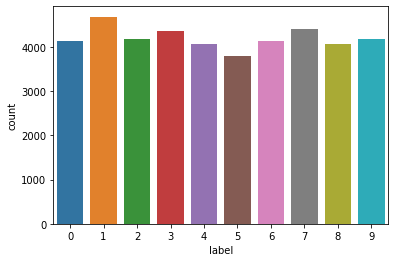

In [6]:
sns.countplot(y_train)
plt.show()

As we can see, our problem is well balanced. Considering the size of the dataset, all classes have approximately the same number of occurrences. $\textbf{This is good}$. To begin with, we won't need to address class balance with extra tools. For a well-balanced problem, $\textit{Accuracy}$ is usually a good score to track learning. In other cases, it is convenient to pay more attention to other scores such as $\textit{Recall}$, $\textit{Precision}$ or $\textit{F1-score}$

### Noise characterization and filtering

In the following section we will analyse different sources of noise and how to identify and characterize them.
First, let's have a look at our images. We have to reorder the instances of our dataset to regain the original images. This means converting each $1x784$ vector into a $28x28$ square matrix:


In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = keras.utils.to_categorical(y_train.values, 10)
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

Plotting the images we get:

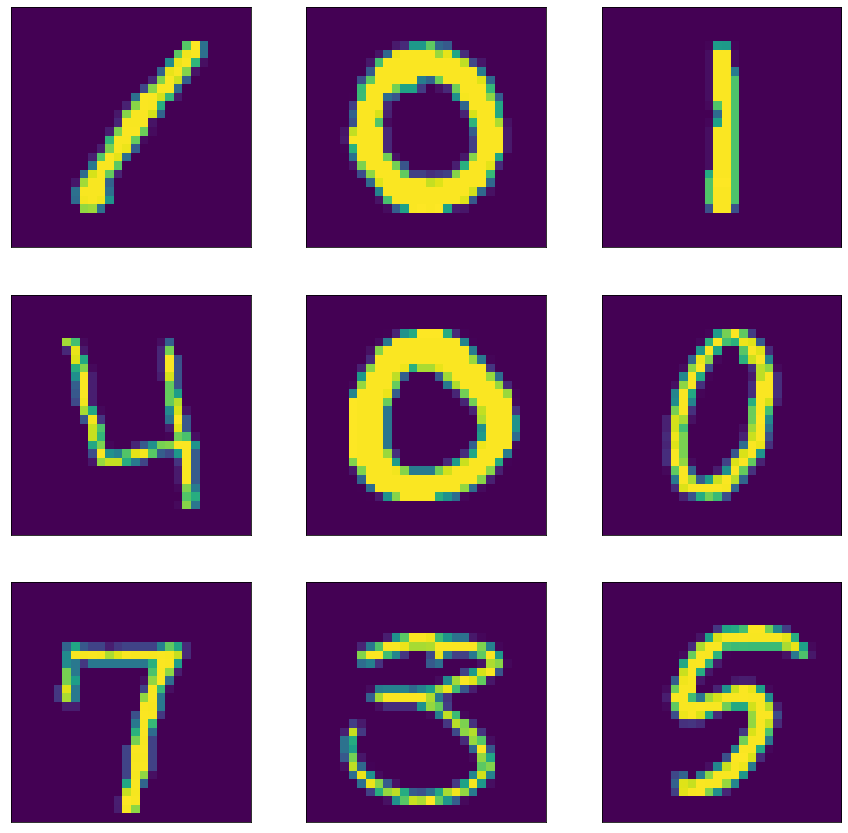

In [8]:
fig = plt.figure(figsize = (15,15))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i][:,:,0])
plt.show()

We see that each instance corresponds to a handwritten number. In addition, we can see that the images are quite clear and have no visible noise. It is known that noise in the training dataset can reduce the accuracy of the model predictions so i's necessary to carry out a quantitative study to better understand the noise in our dataset.

##### Gaussian noise

To begin we make a brief analysis using the $\texttt{estimate_sigma}$ function provided by $\texttt{scikit}$ module. This module measures the standard deviation ($\sigma$) of the  $\texttt{Gaussian noise}$. If the image distribution has a $\sigma$ close to 0 then the image has low $\textit{Gaussian noise}$. On the other hand, normal Gaussian noise has a $\sigma = 1$, so if a image has a $sigma$ close to $1$, it's said to have high Gaussian noise.


In [15]:
import skimage.data
from skimage import img_as_float
from skimage.restoration import estimate_sigma
sigma_vec = []
noise_vec = []
for imnumber in range(0,X_train.shape[0]):
    image = X_train[imnumber][:,:,0]
    noise = np.random.standard_normal(size = image.shape)
    sigma_image = estimate_sigma(image)
    sigma_noise = estimate_sigma(noise)
    sigma_vec.append(sigma_image)
    noise_vec.append(sigma_noise)
mean_sigma = np.mean(sigma_vec)
mean_noise = np.mean(noise_vec)
print('\n', 'Mean standard deviation of our dataset:', mean_sigma, '\n',
'Mean standard deviation of  white noise ensemble:', mean_noise)


 Mean standard deviation from our dataset: 0.0710275309741942 
 Mean standard deviation from a white noise ensemble: 0.9632921571214835


As we expected, the mean standard deviation of our dataset is considerably lower than that one corresponding to an ensemble of images with Gaussian noise.
We can test how this works by adding noise to one of our images. Let's see how the $sigma$ quantifies the Gaussian noise by comparing an image with and without Gaussian noise.

First, we plot the handwritten digit and the Gaussian noise separately.

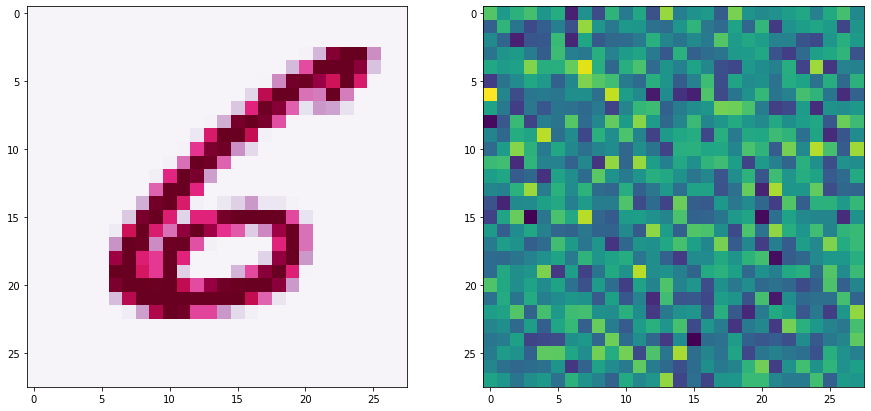

In [18]:
number = X_train[3252][:,:,0]
random_im = np.random.standard_normal(size = imagen.shape)
fig = plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(number, cmap = 'PuRd')
plt.subplot(1,2,2)
plt.imshow(random_im)

Then we calculate the $sigma$ of each image: 

In [19]:
sigma_number = estimate_sigma(number)
sigma_noise = estimate_sigma(random_im)
print('\n', 'The mean standard deviation the handwritten 6 is:', sigma_number, '\n',
'The mean standard deviation of the noisy image is:', sigma_noise)


 The mean standard deviation the handwritten 6 is: 0.09515176442861432 
 The mean standard deviation of the noisy image is: 0.8700879340495004


Now, adding the noise to the digit image we get:

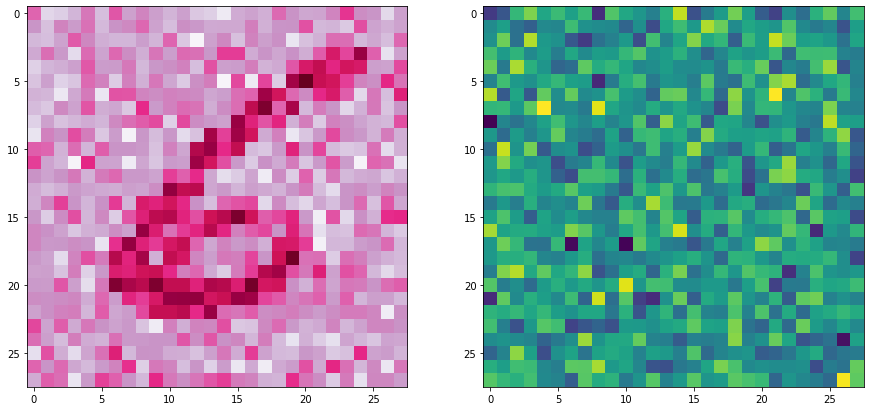

In [23]:
noise_six = X_train[3252][:,:,0] +  0.3*np.random.standard_normal(size = imagen.shape)
random_im = np.random.standard_normal(size = image.shape)
fig = plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(noise_six, cmap = 'PuRd')
plt.subplot(1,2,2)
plt.imshow(random_im)

In [24]:
sigma_noise_six = estimate_sigma(noise_six)
sigma_noise = estimate_sigma(random_im)
print('\n', 'The mean standard deviation the handwritten 6 is :', sigma_noise_six, '\n',
'The mean standard deviation of the noisy image is:', sigma_noise)


 The mean standard deviation the handwritten 6 is : 0.32013462649928814 
 The mean standard deviation of the noisy image is: 0.9918739531311274


We can see that the sigma of the image with Gaussian noise is closer to 1.

Even though $sigma$ it's a good measurement of the presence of Gaussian noise in an image, this parameter is not determinative because values close to $1$ (even greater than $1$) may not necessarily come from normal noise. So once noise is detected, further analysis is needed. In our case, we can rule out the presence of images with a lot of Gaussian noise. However, the images could present other forms of noise such as a periodic pattern or uniform noise.

##### Uniform noise

To study uniform noise in our data we will perform a statistical analysis. We will compare the distribution of the mean intensity of our images and the mean intensity of an ensemble of images with uniform intensities. This will become clearer soon.

The $\textbf{Central Limit Theorem}$ (CLT) states that if a random variable $S$, is the mean of independent random variables, i.e., $S =\frac {X_1+ \dots + X_n} {n}$, then the distribution of $S$ will be approximately a normal distribution for large n. If this random variables $X_i$ have the same distribution, with $\mu$ and $\sigma$, then the distribution of $S$ will be aproximatelly ~$N(\mu,\sigma/\sqrt{n})$


For our problem we can build S as the sum of each pixels intensity, i.e., we sum the intensity of each of the $784$ pixels, denoting the intensity of one pixel as $X_i$ our S can be written as:

$$
\begin{equation}
S =  \frac{1}{748}\sum_i^{784}X_i
\end{equation}
$$



To exemplify this let's take a look at the distribution of the mean intensity of an ensemble of images with uniform intensity in each pixel. We will use the same number of images than in our $\textit{train set}$.

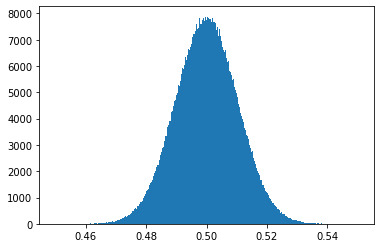

In [54]:
vec = []
for i in range(0,1000000):
    img = np.random.uniform(size = (28, 28))
    vec.append(img.mean())
plt.hist(vec, bins = 500, rwidth = 2) 
plt.show()

In [56]:
np.mean(vec)

0.49999115837357694

In [58]:
estimate_sigma(np.array(vec))

0.010310765271709628

As the CLT tells us, the sigma of $S$ should be close to $\sigma/\sqrt{n}$, in our case $X_i$ comes from a uniform distribution ($\sigma = \frac{1}{\sqrt{12}}$), then $\sigma_S$ ~ $\frac{1}{\sqrt(12)}\frac{1}{\sqrt{748}}$

In [55]:
1/np.sqrt(12*784)

0.010309826235529031

As we can se in the previous pictures and calculations, $S$ has approximately a gaussian distribution. Because the intensities range from $0$ to $1$ then the average of $S$ is going to be $\mu = 0.5$. Now that we know how a eneseble of images made of uniform noise behaves, we are going to compare it with the distribution build from our dataset. So the closer our dataset distribution is to the noise dsitribution will say it's noiser. Next we show the distributions of: our data set, our dataset with uniform noise and the uniform noise ensemble:

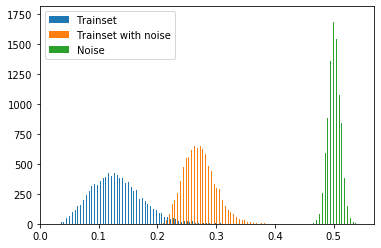

In [32]:
img_number = X_train.shape[0]
vec = []
vec2 = []
vec3 = []
for i in range(0,img_number):
    img =  X_train[i][:,:,0] 
    img = img/img.max()
    vec.append(img.mean())
    img = X_train[i][:,:,0]  + 0.6*np.random.uniform(size = (28, 28))
    img = img/img.max()
    vec2.append(img.mean())
    img = np.random.uniform(size = (28, 28))
    img = img/img.max()
    vec3.append(img.mean())
plt.hist([vec, vec2, vec3], bins = 500, rwidth = 2, label = ['Trainset', 'Trainset with noise', 'Noise'])
plt.legend(loc = 'upper left')
plt.show()

In [53]:
sigma_trainset =  estimate_sigma(np.array(vec))
sigma_noisy_trainset = estimate_sigma(np.array(vec2))
sigma_noise = estimate_sigma(np.array(vec3))

mean_trainset = np.mean(vec)
mean_noisy_trainset = np.mean(vec2)
mean_noise = np.mean(vec3)

print('\n', 'The sigma of the trainset is:', sigma_trainset,
     '\n', 'The sigma of the trainset with uniform noise is:', sigma_noisy_trainset,
     '\n', 'The sigma of noise is:', sigma_noise,
     '\n', 'The mean of the trainset set:', mean_trainset,
     '\n', 'The of the train set with uniform noise is:', mean_noisy_trainset,
     '\n', 'The mean of the uniform noise is:', mean_noise,)


 The sigma of the trainset is: 0.04309035996190209 
 The sigma of the trainset with uniform noise is: 0.02652239796129484 
 The sigma of noise is: 0.010183490205720227 
 The mean of the trainset set: 0.1310661494565955 
 The of the train set with uniform noise is: 0.27275844916576936 
 The mean of the uniform noise is: 0.500627478518369


This way, we have a set of parameters to compare our distribution with the characteristic distribution of uniform noise. We see that our dataset has an average of $\mu_{train} = 0.1$ while the characteristic noise $\mu_{noise} = 0.5$. In addition, we see that the distribution of the train set with added noise is positioned, as expected, with an average that falls between the previous two. On the other hand, we see that the distribution of the train set presents a variance 4 times greater than that of the noise. With this analysis, and for this particular case, we could conclude that our dataset does not present a considerable amount of uniform noise either. However, for a more conclusive analysis, we would have to weigh these mentioned parameters plus those obtained by a Gaussian fit to each distribution. An analysis of the type $\chi^2$ could be useful to give us an idea of how similar our dataset is to the characteristic distribution of uniform noise.

Again, this simple analysis can guide us or give us an idea of the presence of uniform noise but it is not conclusive and its result could infer different things. For example, a sufficiently pathological dataset could result in a Gaussian distribution similar to that resulting from a uniform noise assembly. Suspecting that our dataset is low noise, we will use the $\texttt{ndimage}$ module of $\texttt{scipy}$. We will try to recover the noise from our images by subtracting the non-noisy information using different filters and subtracting the filtered image from the post image to obtain the noise.

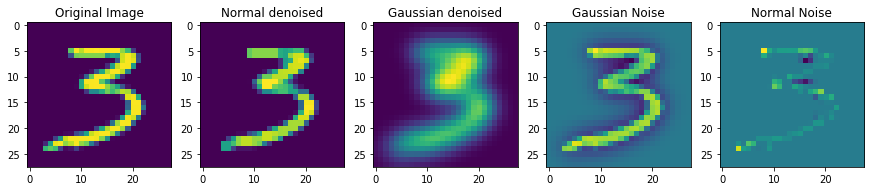

In [301]:
from scipy import ndimage

image =  X_train[25][:,:,0] 
gauss_denoised = ndimage.gaussian_filter(image, 2)
med_denoised = ndimage.median_filter(image, 3)
gauss_noise = X_train[25][:,:,0]  - gauss_denoised
med_noise = X_train[25][:,:,0]  - med_denoised

fig = plt.figure(figsize = (15,15))
plt.subplot(1,5,1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1,5,2)
plt.title('Normal denoised')
plt.imshow(med_denoised)
plt.subplot(1,5,3)
plt.title('Gaussian denoised')
plt.imshow(gauss_denoised)
plt.subplot(1,5,4)
plt.title('Gaussian Noise')
plt.imshow(gauss_noise)
plt.subplot(1,5,5)
plt.title('Normal Noise')
plt.imshow(med_noise)

We can conclude that our data set has low noise. In this case we should be careful when applying gaussian filters. If we look at the previous cell, we see that the result of having applied this filter is a $\textit{blurred}$ image. We start from a clear and low noise image and we obtain an image in which all the clear edges have been filtered. This is a price that someone might want to pay if the dataset has a considerable amount of noise. Otherwise, it is advisable not to use this type of filter. On the other hand, we see that the result of removing the average noise is practically unchanged from the original image. This is to be expected in low noise images. 

##### Periodical noise

To have a complete analysis of the most common sources of noise we'll also analyse the periodical noise. In these case it's useful to look a the two dimensional Fourier transform. Let's look at what happens when we add a periodic pattern to one of our images.

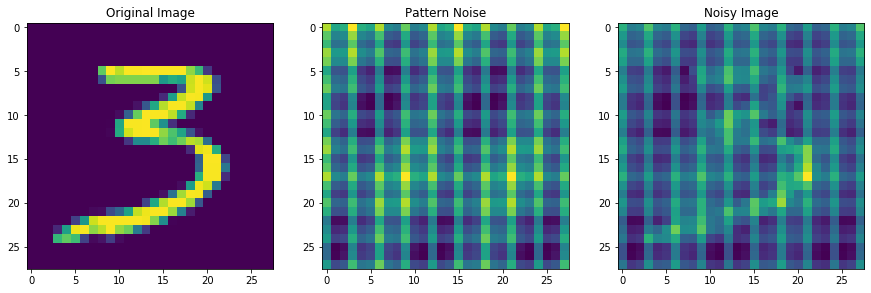

In [36]:
[X,Y] = np.meshgrid(2*np.pi * np.arange(28)/12,2*np.pi * np.arange(28)/34)
circles = np.sin(Y+X) +  np.cos(10* Y) + np.cos(2* Y) + np.cos(4* X) + np.cos(4* X)  #+ np.random.uniform(0,0.02,X.shape)
fig = plt.figure(figsize = (15,15))
image =  X_train[25][:,:,0] 
pattern_number = image + 0.3*circles
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1,3,2)
plt.title('Pattern Noise')
plt.imshow(circles)
plt.subplot(1,3,3)
plt.title('Noisy Image')
plt.imshow(pattern_number)

Then we analyze the frequencies of the periodic noise by looking at the Fourier transform of the noisy image:

Text(0.5, 1.0, 'Fourier transform')

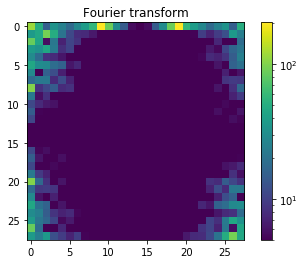

In [37]:
from scipy import fftpack
im_fft = fftpack.fft2(pattern_number)
def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')

The frequencies present in the noise are the high intensity peaks in the matrix, these correspond to the noise that we added. To filter  these noise all we have to do is  remove these high intensity matrix elements:

Text(0.5, 1.0, 'Filtered Spectrum')

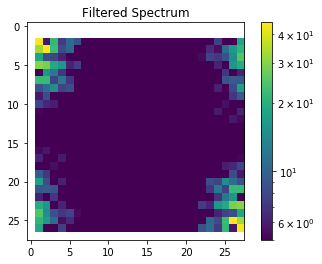

In [44]:
im_fft2 = im_fft.copy()
im_fft2[[0,1,27],:] = 0
im_fft2[:, 0:1] = 0

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

Our image can be recovered by calculating the inverse Fourier transform:

Text(0.5, 1.0, 'Reconstructed Image')

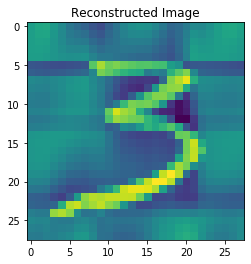

In [45]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new)
plt.title('Reconstructed Image')

We have reconstructed  the image but without the noise pattern!

All the previous techniques can be usued to filter the different types of noise and get more quality pictures to train our models.

### CNN Analisys

Finally, we test different architectures of convolutional neural networks and discuss some of its characteristics. First we reserve a $20\%$ fraction of the train set to cross-validate during training.

In [5]:
#Split train test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_seed)

Next we define some important parameters, the activation function,  loss functions and the metric for training. The activation function it's an operation over each neuron that turns the neuron on or off depending on the input value. The most basic activation function is the step function. In this case we use either $\textit{ReLU}$ or $\textit{Rectified Linear Unit}$. This last activation function is especially optimized for deep convolutional networks. It has certain advantages such as numerical ease in the algebraic operations involved and provides better convergence as it minimizes the problems of $\textit{gradient vanishing}$.

We used $\textit{categorical cross entropy}$ as a loss function. This function is usual in multiclass problems, where the entropy of the probability distribution of each class is assigned as loss. In addition, in this kind of classification problem, where the correct prediction is only one, it is useful to use this entropy where the only non-zero term of entropy is the one corresponding to the positive class.

Finally, we choose to use $\textit{accuracy}$ as the metric, which is the most intuitive and easy for problems with good balance of classes.

In [46]:
#CNN
#hyperparams
activation = 'relu'
#initializer = keras.initializers.lecun_uniform(seed=42)
filters = 32
kernel_size = (5,5)
init_learning_rate = 0.001

loss = 'categorical_crossentropy'
epochs = 30
dataset_size = X_train.shape[0]
batch_size = 86
metric = ['accuracy']

The $\texttt{ReduceLROnPlateau}$ algorithm updates the value of the learning rate when the minimization of the loss function is stalled in the learning process. It is a dynamic way to optimize network parameters without having to stop training.

In [47]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)


The most basic convolutional network structure possible is show below. It is a 2D convolution layer. This layer performs convolutions of the image with different filters. In this case, the number of filters is $\texttt{filters = 32}$. Each filter "concentrates" on a particular aspect of the image. For example, one filter focuses on the horizontal lines, another on the vertical lines, and another on the diagonals. Another filter can focus on circular shapes, $\textit{and so on...}$ In this way, we get a "breakdown" of 32 images that hold a particular aspect of our input image. The filters are printed on a smaller matrix called $\textit{kernel}$. In this case $\texttt{kernel_size} = (5.5)$. 

The output layer consists of $\texttt{Flatten}$ and $\texttt{Dense}$. The first one, only converts the input to a vector of one dimension, as is usually done in the output of any NN. $\texttt{Dense}$ is a layer that by definition has a neuron for each $\texttt{feature}$. In this case, one for each pixel. It transforms the input into the desired shape and dimension. In this case, a vector of 256 elements, one for each possible pixel value. Finally, the output is converted to a probability distribution of each of the $10$ classes.

In [48]:
model = Sequential()
#input layer
model.add(Conv2D(filters = filters, kernel_size = kernel_size,
                 strides = 1, padding = 'Same',
                 activation =activation, input_shape = (28,28,1)))


#output layer
model.add(Flatten())
model.add(Dense(256, activation = activation)) #dense de 2^n
model.add(Dense( 10,activation = 'softmax'))

Let's see the neetwork structure:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 6,426,186
Trainable params: 6,426,186
Non-trainable params: 0
_________________________________________________________________


The optimization algorithm used is $\texttt{RMSprop}$. It owes its fame to its great capacity of convergence, being considerably faster and more effective than the rest. In addition, the module $\texttt{Keras}$ suggests not change the default hyperparameters because they are already optimized. Having chosen the optimizer, we trained this first model:

In [17]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

history1 = model.fit(X_train,y_train, epochs = 6,  batch_size = batch_size, validation_data = (X_val,y_val), callbacks = [lr_reduction])

Train on 33600 samples, validate on 8400 samples
Epoch 1/6
33600/33600 [==============================] - 50s 1ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0781 - val_acc: 0.9856
Epoch 2/6
33600/33600 [==============================] - 51s 2ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0861 - val_acc: 0.9838

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/6
33600/33600 [==============================] - 51s 2ms/step - loss: 6.5489e-04 - acc: 0.9999 - val_loss: 0.0823 - val_acc: 0.9854

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/6
33600/33600 [==============================] - 50s 1ms/step - loss: 4.9125e-04 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9861
Epoch 5/6
33600/33600 [==============================] - 51s 2ms/step - loss: 4.8999e-04 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9860

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 6/6
336

Two things stand out from the previous training. The first is that the score obtained is considerably good. This is due to the fidelity and large amount of images. For such a big dataset, with a generic convolutional network like the one tested previously, it is practically immediate to obtain an $\textit{accuracy}$ of $98.7\%$ if the network hyperparameters are properly chosen. However a better architecture can yield scores of $99.7\%$. Then, a good performance for this case is played on the second or third significant digit of the metric in question. The second remarkable thing is that, as we see in the difference between validation and training metrics, in this case the training presents a considerable $\textit{overfitting}$. We can see that the validation accuracy is $acc_{val} = 0.987$ while the training accuracy is $acc_{train} = 0.999$. The same is indicated by the relationship between the loss functions. 

A good method to counteract the tendency to overfitting is to increase the size of our dataset. For this, we can take the images we have and deform them with stretches and rotations to simulate more samples. We will use Keras' $\texttt{ImageDataGenerator}$ module.

In [19]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.0, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

We train again the same network with the augmented dataset.

In [20]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              steps_per_epoch=500, validation_data=[X_val, y_val],
                              epochs = 10,
                             callbacks=[lr_reduction])

Epoch 1/10
500/500 [==============================] - 67s 135ms/step - loss: 0.2003 - acc: 0.9445 - val_loss: 0.0416 - val_acc: 0.9852
Epoch 2/10
500/500 [==============================] - 66s 132ms/step - loss: 0.0965 - acc: 0.9715 - val_loss: 0.0451 - val_acc: 0.9858
Epoch 3/10
500/500 [==============================] - 67s 133ms/step - loss: 0.0797 - acc: 0.9759 - val_loss: 0.0320 - val_acc: 0.9886
Epoch 4/10
500/500 [==============================] - 69s 137ms/step - loss: 0.0688 - acc: 0.9793 - val_loss: 0.0345 - val_acc: 0.9890
Epoch 5/10
500/500 [==============================] - 66s 132ms/step - loss: 0.0618 - acc: 0.9820 - val_loss: 0.0286 - val_acc: 0.9910
Epoch 6/10
500/500 [==============================] - 66s 132ms/step - loss: 0.0563 - acc: 0.9832 - val_loss: 0.0361 - val_acc: 0.9886

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - loss: 0.0455 - acc: 0.9867 - val_loss

As we can see, we have solved the issue of overfitting. Moreover, by increasing the size of the dataset, the performance has improved substantially, obtaining a validation accuracy of $0.992\%$ (in a larger number of epochs it can reach $0.993\%$). However, we know that with a better architecture and using some typical tools of the convolutional neural networks, this score can improve substantially. In particular, we will add two types of layers that improve performance: $\textit{Max Pooling}$ and $\textit{Drop Out}$. 

Before testing the result with these tools, a brief explanation of how each one works. $\textit{Max Pooling}$ is in some sense a dimensional reduction tool. It scans the image and keeps the largest pixel value in a given group, which size can be tuned. In this way, after its application, an image with a smaller dimension is obtained which, theoretically, retains the main characteristics. This allows, for example, to double the number of convolution filters without increasing the number of neurons. On the other hand, $\textit{Drop Out}$ works as a shutter of neurons. It randomly nullifies a certain fraction of the neurons in the layer in which it is used. In this way, in each action of the layer different neurons are activated preventing the crystallization of preferential learning paths and providing robustness to the network by distributing the learning capacity uniformly. Let's see its performance:

In [22]:
model = Sequential()
#input layer
model.add(Conv2D(filters = filters, kernel_size = kernel_size,
                 strides = 1, padding = 'Same',
                 activation =activation, input_shape = (28,28,1)))
model.add(Conv2D(filters = filters, kernel_size = kernel_size,
                 strides = 1, padding = 'Same',
                 activation =activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 strides = 1, padding = 'Same',
                 activation =activation))
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 strides = 1, padding = 'Same',
                 activation =activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.15))

#output layer
model.add(Flatten())
model.add(Dense(256, activation = activation)) #dense de 2^n
model.add(Dropout(0.45))
model.add(Dense( 10,activation = 'softmax'))

In [23]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              steps_per_epoch=500, validation_data=[X_val, y_val],
                              epochs = 15,
                             callbacks=[lr_reduction])

Epoch 1/15
500/500 [==============================] - 103s 207ms/step - loss: 0.3586 - acc: 0.8849 - val_loss: 0.0477 - val_acc: 0.9836
Epoch 2/15
500/500 [==============================] - 104s 208ms/step - loss: 0.1044 - acc: 0.9691 - val_loss: 0.0345 - val_acc: 0.9887
Epoch 3/15
500/500 [==============================] - 103s 206ms/step - loss: 0.0764 - acc: 0.9773 - val_loss: 0.0412 - val_acc: 0.9861

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/15
500/500 [==============================] - 104s 207ms/step - loss: 0.0495 - acc: 0.9854 - val_loss: 0.0222 - val_acc: 0.9924
Epoch 5/15
500/500 [==============================] - 104s 208ms/step - loss: 0.0431 - acc: 0.9867 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 6/15
500/500 [==============================] - 102s 205ms/step - loss: 0.0407 - acc: 0.9876 - val_loss: 0.0191 - val_acc: 0.9945
Epoch 7/15
500/500 [==============================] - 106s 212ms/step - loss: 0.0396 - acc: 0.9880 - v

As we can see, performance has improved substantially, reaching the expected values. In this case we show a training of few iterations. The performance can even improve with a higher number of epochs. 

In summary, convolutional neural networks are particularly preferred for image detection, recognition or classification. In this article, basic notions and structure of this type of networks have been presented for the classification of a "toy" dataset. In a more realistic case with noisy and larger images, a more thorough analysis of the parameter and species configuration and number of layers will be necessary to achieve good results. In addition, pre-processing of the data is crucial to exploit the power of this type of model.